# Лабораторная работа 1. Кластерный анализ
Выполнил: студент гр. АСМ-18-04, Макаров И.Д.

In [1]:
#pip install ipywidgets
#jupyter nbextension enable --py widgetsnbextension

#pip install open3d
# Если после установки данной библиотеки появится ошибка
# "ImportError: DLL load failed: Не найден указанный модуль.",
# то установите х86 и х64 версии VisualC++ Redistributable 2015/2017/2019 
# и перезагрузите компьютер (проверено на Windows8.1 x64).
# Установочные файлы находятся в папке "VC++ 15,17,19".

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from sklearn import cluster
from IPython.display import Image
from ipywidgets import IntProgress
from IPython.display import display
import time

### 1. Кластеризация облака точек
### Первичная визуализация облака точек

In [2]:
file_path = "LR1_data/point_clouds/room_scan1.pcd"
point_cloud = o3d.io.read_point_cloud(file_path)

o3d.visualization.draw_geometries([point_cloud], window_name='Primary visualization of a point cloud')

### 1.1 Кластеризация методом k-means

In [3]:
# Найдём границы облака точек
pcarr = np.asarray(point_cloud.points)
limits = [[min(pcarr[:,i]), max(pcarr[:,i])] for i in range(3)]

IntProgress(value=1, description='0%', max=30, min=1)

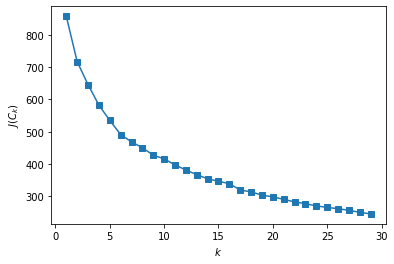

In [17]:
str1 = '0%'
prgBar = IntProgress(min = 1, max = 30, description=str1)
display(prgBar)

# Выберем число кластеров по правилу "локтя".
# Для этого постороим график зависимости инерции от числа кластеров
inertia = []
for k in range(1, 30):
    kmeans = cluster.KMeans(n_init=1, n_clusters=k, random_state=1, n_jobs=-1).fit(pcarr)
    inertia.append(np.sqrt(kmeans.inertia_))
    
    prgBar.value = k+1
    prgBar.description = str('{:.1f}%'.format(prgBar.value*100/30))
    time.sleep(0.1)

plt.plot(range(1, 30), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видно, что в интервале от 10 до 20 кластеров скорость уменьшения инерции падает 

In [44]:
# Разобъём параллелепипед на подпространства,
# где n_subspaces - число интервалов по каждой оси,
# а n_dots - число границ инервалов
n_subspaces = 10
n_dots = n_subspaces + 1
stop = n_dots**3

sublimits = [[limits[0][0] + (i%n_dots)*(limits[0][1] - limits[0][0])/n_subspaces,
              limits[1][0] + ((i//n_dots)%n_dots)*(limits[1][1] - limits[1][0])/n_subspaces,
              limits[2][0] + (i//n_dots**2)*(limits[2][1] - limits[2][0])/n_subspaces] for i in range(stop)]

In [45]:
# Найдём индексы точек из исходного облака, которые принадлежат каждому подпространству
stop = n_dots**3
idx = [np.where(np.all(pcarr>=sublimits[i], axis=1)*np.all(pcarr<=sublimits[i+n_dots*(n_dots+1)+1], axis=1))[0] for i in range(stop) if ((i+1)%n_dots != 0) and ((i//n_dots+1)%n_dots != 0) and ((i//n_dots**2+1)%n_dots != 0)]

In [46]:
# Пусть максимально возможное число кластеров в подпространстве max_cluster_num
max_cluster_num = 10
stop = n_subspaces**3

# коэффициент пропорциональности k
max_dots = max((len(idx[i]) for i in range(stop)))
k = max_cluster_num/max_dots

# тогда число исходных кластеров в каждом подпространстве
init_n_clusters = [int(np.floor(len(idx[i])*k)) for i in range(stop)]

In [47]:
# Найдём координаты центроидов для инициализации
stop = n_subspaces**3
init_clustering = [cluster.KMeans(n_init=1, n_clusters=init_n_clusters[i]).fit(pcarr[idx[i]]) for i in range(stop) if init_n_clusters[i]>0]

stop = len(np.nonzero(init_n_clusters)[0])
init_centroids = np.vstack([init_clustering[i].cluster_centers_ for i in range(stop)])

In [48]:
# Выполним кластеризацию.
# Параметры кластеризации:
# - число прогонов алгоритма n_init
# - число кластеров n_clusters
# - число генераций для генератора случайных чисел random_state
# - координаты исходных центроидов init
# - параметр для параллельных вычислений n_jobs (-1 означает использование всех процессоров)

n_clusters_ = len(init_centroids)
prep_kmeans = cluster.KMeans(n_init=10, n_clusters=n_clusters_, random_state=5, init=init_centroids, n_jobs=-1).fit(pcarr)

In [49]:
# Преобразуем полученных координат центроидов в облако точек
centroids = prep_kmeans.cluster_centers_
centroids_pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(centroids))
colors = [[1,0,0] for x in range(n_clusters_)]
centroids_pcd.colors = o3d.utility.Vector3dVector(colors)

In [50]:
# Определим цвета для каждого кластера
point_mask = prep_kmeans.labels_
colors = [[0.3, (x+1)/n_clusters_, 0.1] for x in point_mask]
point_cloud.colors = o3d.utility.Vector3dVector(colors)

### Визуализация облака точек после кластеризации

In [52]:
o3d.visualization.draw_geometries([point_cloud, centroids_pcd], window_name='K-means clustering visualization')

### 1.2 Кластеризация методом Aglomerative clustering

In [53]:
# Разобъём параллелепипед на подпространства,
# где n_subspaces - число интервалов по каждой оси,
# а n_dots - число границ инервалов
n_subspaces = 15
n_dots = n_subspaces + 1
stop = n_dots**3

sublimits = [[limits[0][0] + (i%n_dots)*(limits[0][1] - limits[0][0])/n_subspaces,
              limits[1][0] + ((i//n_dots)%n_dots)*(limits[1][1] - limits[1][0])/n_subspaces,
              limits[2][0] + (i//n_dots**2)*(limits[2][1] - limits[2][0])/n_subspaces] for i in range(stop)]

In [54]:
# Найдём индексы точек из исходного облака, которые принадлежат каждому подпространству
stop = n_dots**3
idx = [np.where(np.all(pcarr>=sublimits[i], axis=1)*np.all(pcarr<=sublimits[i+n_dots*(n_dots+1)+1], axis=1))[0] for i in range(stop) if ((i+1)%n_dots != 0) and ((i//n_dots+1)%n_dots != 0) and ((i//n_dots**2+1)%n_dots != 0)]

In [55]:
# Пусть максимально возможное число кластеров в подпространстве max_cluster_num
max_cluster_num = 15
stop = n_subspaces**3

# коэффициент пропорциональности k
max_dots = max((len(idx[i]) for i in range(stop)))
k = max_cluster_num/max_dots

# тогда число исходных кластеров в каждом подпространстве
init_n_clusters = [int(np.rint(len(idx[i])*k)) for i in range(stop)]

In [59]:
# Выполним кластеризацию
stop = n_subspaces**3
agl_clustering = [cluster.AgglomerativeClustering(affinity='manhattan', linkage='single', n_clusters=init_n_clusters[i]).fit(pcarr[idx[i]]) for i in range(stop) if init_n_clusters[i]>0]

stop = len(np.nonzero(init_n_clusters)[0])
labels = [agl_clustering[i].labels_ for i in range(stop)]

In [60]:
# Определим цвета для каждого кластера
# Некластеризованные точки закрасить чёрным
stop = len(labels)
n = [max(labels[i])+1 for i in range(stop)]
colors = np.vstack([[[0.1, (x+1)/n[i], i/stop] for x in labels[i]] for i in range(stop)])

stop = n_subspaces**3
clustered_pcd = np.concatenate([pcarr[idx[i]] for i in range(stop) if init_n_clusters[i]>0])
non_clustered_pcd = np.concatenate([pcarr[idx[i]] for i in range(stop) if init_n_clusters[i]==0])

stop = len(non_clustered_pcd)
nc_colors = [[0, 0, 0] for i in range(stop)]

clustered_pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(clustered_pcd))
non_clustered_pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(non_clustered_pcd))

clustered_pcd.colors = o3d.utility.Vector3dVector(colors)
non_clustered_pcd.colors = o3d.utility.Vector3dVector(nc_colors)

### Визуализация облака точек после кластеризации

In [61]:
o3d.visualization.draw_geometries([clustered_pcd, non_clustered_pcd], window_name='Aglomerative clustering visualization')

### 1.3 Кластеризация методом DBSCAN

In [ ]:
# Выполним кластеризацию
dbscan = cluster.DBSCAN(eps=0.2, min_samples=100, leaf_size=400, n_jobs=-1).fit(pcarr)

In [ ]:
# Определим цвета для каждого кластера
point_mask = dbscan.labels_
n_clusters_ = max(point_mask)
colors = [[0.1, x/n_clusters_, 0.2] if x>=0 else [0,0,0] for x in point_mask]
point_cloud.colors = o3d.utility.Vector3dVector(colors)

In [ ]:
o3d.visualization.draw_geometries([point_cloud], window_name='DBSCAN clustering visualization of entire point cloud')

In [38]:
# Разобъём параллелепипед на подпространства,
# где n_subspaces - число интервалов по каждой оси,
# а n_dots - число границ инервалов
n_subspaces = 6
n_dots = n_subspaces + 1
stop = n_dots**3

sublimits = [[limits[0][0] + (i%n_dots)*(limits[0][1] - limits[0][0])/n_subspaces,
              limits[1][0] + ((i//n_dots)%n_dots)*(limits[1][1] - limits[1][0])/n_subspaces,
              limits[2][0] + (i//n_dots**2)*(limits[2][1] - limits[2][0])/n_subspaces] for i in range(stop)]

In [39]:
# Найдём индексы точек из исходного облака, которые принадлежат каждому подпространству
stop = n_dots**3
idx = [np.where(np.all(pcarr>=sublimits[i], axis=1)*np.all(pcarr<=sublimits[i+n_dots*(n_dots+1)+1], axis=1))[0] for i in range(stop) if ((i+1)%n_dots != 0) and ((i//n_dots+1)%n_dots != 0) and ((i//n_dots**2+1)%n_dots != 0)]

In [40]:
# Выполним кластеризацию
stop = n_subspaces**3
dbs_clustering = [cluster.DBSCAN(eps=0.2, min_samples=60, leaf_size=80, n_jobs=-1).fit(pcarr[idx[i]]) for i in range(stop) if len(idx[i])>0]

In [41]:
stop = n_subspaces**3
buf = [len(idx[i]) for i in range(stop)]

stop = len(np.nonzero(buf)[0])
labels = [dbs_clustering[i].labels_ for i in range(stop)]

In [42]:
# Определим цвета для каждого кластера
stop = len(labels)
n = [max(labels[i]) for i in range(stop)]
colors = np.vstack([[[0.1, x/n[i], i/stop] if x>=0 else [0,0,0] for x in labels[i]] for i in range(stop)])

stop = n_subspaces**3
clustered_pcd = np.concatenate([pcarr[idx[i]] for i in range(stop) if len(idx[i])>0])
clustered_pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(clustered_pcd))

clustered_pcd.colors = o3d.utility.Vector3dVector(colors)

### Визуализация облака точек после кластеризации

In [43]:
o3d.visualization.draw_geometries([clustered_pcd], window_name='DBSCAN clustering visualization of subdivided point cloud')

### 2. Уменьшение числа оттенков в изображении

In [62]:
# Определим функцию для приведения исходного изображения к матрице размерности [n_samples, n_features]
def Reshape(img):
    np_img = np.asarray(img)
    vsize = len(np_img)
    hsize = len(np_img[0])
    np_img = np.vstack(np_img)
    return np_img, vsize, hsize

In [63]:
# Импортируем изображение
src_file = "LR1_data/shade_num_reducing/source_img.jpg"
src_img = o3d.io.read_image(src_file)

# Преобразуем изображение в матрицу [n_pixels, 3], где строки представлены пикселями,
# а столбцы - значениями интенсивности цвета: красный 0-255, зелёный 0-255, синий 0-255.
np_img, vsize, hsize = Reshape(src_img)

In [64]:
# Выполним кластеризацию на 8, 16, 32, 64 и 128 кластеров методом k-means,
# что соответствует глубине цвета 8, 16, 32, 64 и 128 бит
nums = [2**x for x in range(3,8)]
stop = len(nums)

kmeans = [cluster.KMeans(n_clusters=num, n_jobs=-1, random_state=1).fit(np_img) for num in nums]
print('Clustering completed')

# Для каждой проведённой кластеризации присвоим каждому пикселю изображения цвет,
# соответсвующий классу, к которому был отнесён пиксель
for index in range(stop):
    centroids = kmeans[index].cluster_centers_
    point_mask = kmeans[index].labels_

    colors = np.uint8(np.asarray([centroids[i] for i in point_mask]))

    colors = colors.reshape(vsize, hsize, 3)
    processed_img = o3d.geometry.Image(colors)

    # Экспортируем полученные изображения
    prc_file = "LR1_data/shade_num_reducing/img_"+str(nums[index])+"bit.png"
    #o3d.io.write_image(prc_file, processed_img, quality=100)

print('Export completed')

Clustering completed
Export completed


In [65]:
# Определим функцию сравнения изображения
def CompareImage(filename1, filename2, method='mse'):

    img1 = o3d.io.read_image(filename1)
    img2 = o3d.io.read_image(filename2)
    img1, _, _ = Reshape(img1)
    img2, _, _ = Reshape(img2)

    if method == 'mse':
        dif = (np.square(np.subtract(img1,img2)).mean())**0.5
    elif method == 'abs':
        dif = np.abs(np.subtract(img1,img2)).mean()
        
    return dif

In [66]:
# Расчитаем средние квадратичные ошибки для каждого изображения
for num in nums:
    prc_file = "LR1_data/shade_num_reducing/img_"+str(num)+"bit.png"
    dif = CompareImage(src_file, prc_file)
    print("Difference between source image and {}-bit image is equal to {:.3f}".format(num, dif))

Difference between source image and 8-bit image is equal to 9.330
Difference between source image and 16-bit image is equal to 8.549
Difference between source image and 32-bit image is equal to 7.663
Difference between source image and 64-bit image is equal to 6.556
Difference between source image and 128-bit image is equal to 5.414


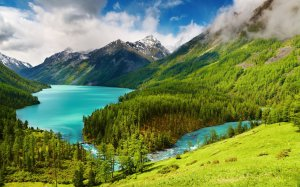

In [67]:
Image(src_file)

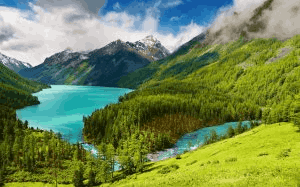

In [68]:
# Изображение с глубиной цвета 128 бит
Image(prc_file)

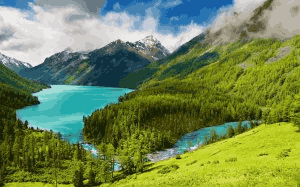

In [75]:
# Изображение с глубиной цвета 64 бит
prc_file = "LR1_data/shade_num_reducing/img_64bit.png"
Image(prc_file)

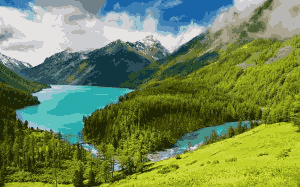

In [76]:
# Изображение с глубиной цвета 32 бит
prc_file = "LR1_data/shade_num_reducing/img_32bit.png"
Image(prc_file)

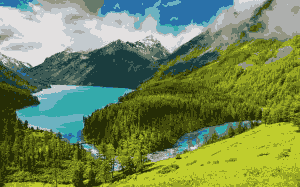

In [77]:
# Изображение с глубиной цвета 16 бит
prc_file = "LR1_data/shade_num_reducing/img_16bit.png"
Image(prc_file)

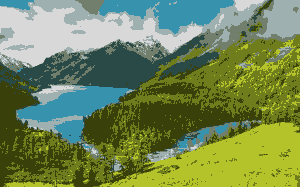

In [78]:
# Изображение с глубиной цвета 8 бит
prc_file = "LR1_data/shade_num_reducing/img_8bit.png"
Image(prc_file)

### 3. Сегментация изображения

In [69]:
# Импортируем изображение и приведём его к матричной форме
src_file = "LR1_data/segmentation/source_img.jpg"
src_img = o3d.io.read_image(src_file)

np_img, vsize, hsize = Reshape(src_img)

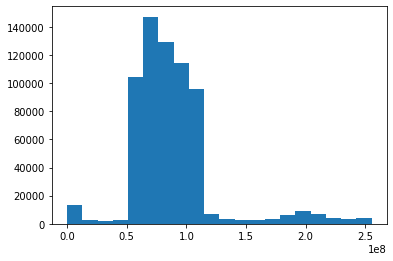

In [70]:
# Представим каждый пиксель в виде линейной комбинации интенсивностей цветов
encoder = [10**6, 10**3, 1]
encode_img = np.dot(np_img, encoder)

# Нарисуем гистограмму распределения пикселей
n, b, _, = plt.hist(encode_img, bins=20)

In [71]:
# Выберем инициализирующие центроиды, исходя из локальных максимумов распределения
stop = len(n)

ind = []
for i in range(stop):
    if i == 0:
        if n[i]>n[i+1]:
            ind.append(i)
    elif i == stop-1:
        if n[i]>n[i-1]:
            ind.append(i)
    else:
        if n[i]>n[i+1] and n[i]>n[i-1]:
            ind.append(i)
# Для каждого из интервалов, соответствующих локальным максимумам, выберем медианный пиксель
buf = [np.median(encode_img[(encode_img>b[i])*(encode_img<b[i+1])]) for i in ind]
# Приведем центроиды к исходному виду: [R, G, B]
init_centroids = np.asarray([[elem//10**6, (elem%10**6)//10**3, elem%10**3] for elem in buf])

In [72]:
# Выполним кластеризацию
kmeans = cluster.KMeans(init=init_centroids, n_clusters=len(init_centroids), n_jobs=-1, random_state=1).fit(np_img)

centroids = kmeans.cluster_centers_
point_mask = kmeans.labels_

# Присвоим каждому пикселю изображения цвет,
# соответсвующий классу, к которому был отнесён пиксель
colors = np.uint8(np.asarray([centroids[i] for i in point_mask]))

colors = colors.reshape(vsize, hsize, 3)
processed_img = o3d.geometry.Image(colors)

# Экспортируем полученное изображение
prc_file = "LR1_data/segmentation/seg_img.png"
#o3d.io.write_image(prc_file, processed_img, quality=100);

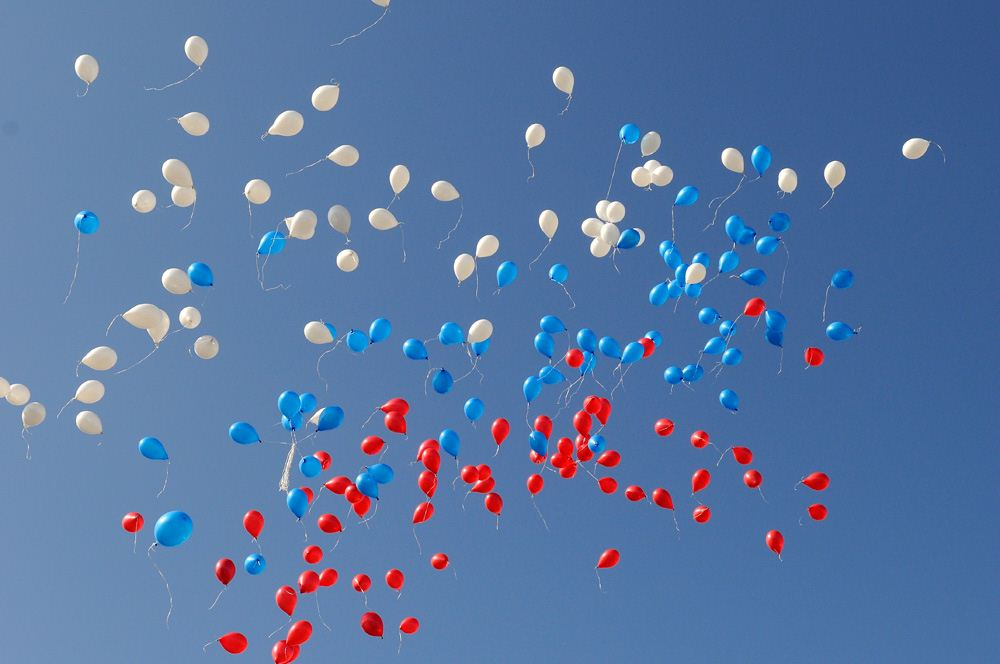

In [73]:
Image(src_file)

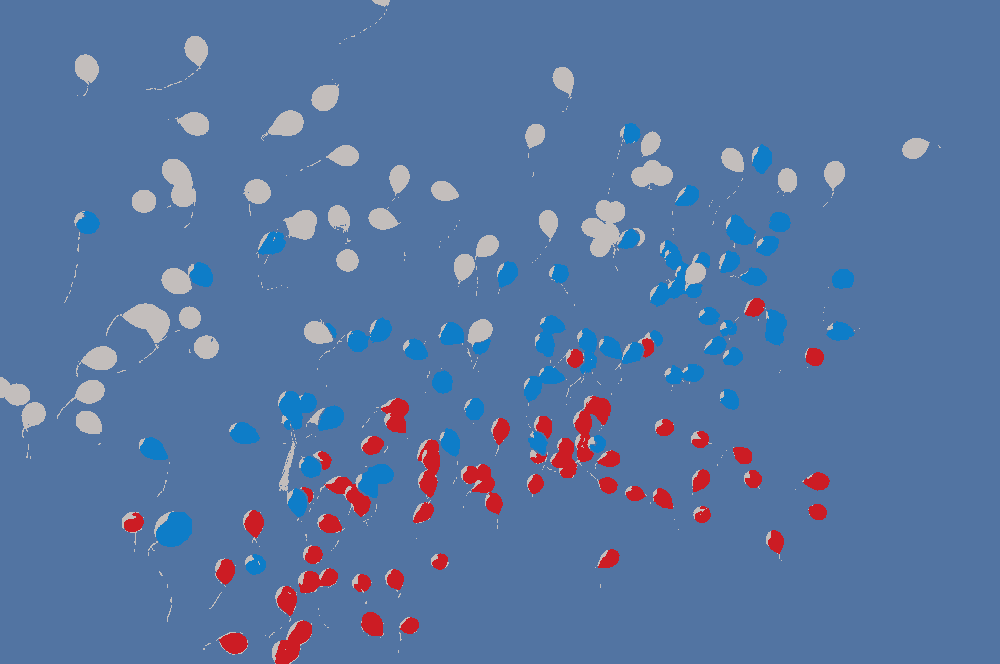

In [74]:
Image(prc_file)

### Выводы
#### Задание 1. Кластеризация облака точек
Исходное облако точек было кластеризовано тремя методами:
1. К-средних
2. Агломеративная иерархическая кластеризация
3. Пространственная кластеризация приложений с шумом на основе плотности

Полученные методом К-средних кластеры отвечают минимуму суммы квадратов Евклидовых расстояний для каждого кластера, поэтому размеры кластеров зависят от плотности точек. Для областей с одинаковой плотностью точек форма кластеров близка к сферической.
В целом, метод один из самых быстрых и не загружает оперативную память.

Для агломеративной иерархической кластеризации важен выбор стратегии и метрики. Используя стратегию *'ward'*, получаем разбиение на разные кластеры как обособленных областей точек, так и неразрывной области. Стратегия *'single'*, или "ближайшего соседа", хорошо кластеризует обособленные области точек. В целом, данный метод чувствителен к размеру кластеризуемых данных, так как работает с оперативной памятью, поэтому, начиная с некоторого количества образцов, для выполнения методу может не хватать памяти, что приводит к появлению ошибки *'Memory error'*.

Метод DBSCAN хорошо работает на данных с одинаковой плотностью. По изображению после кластеризации видно, что в кластеры объединены точки, располагающиеся в некотором диапазоне расстояний от устройства сканирования (в силу особенности процедуры сканирования), и в зависимости от параметра *eps* - расстояния между ближайшими точками - кластеры будут располагаться ближе или дальше от устройства сканирования, т.е. в прямой зависимости от плотности точек. Число кластеров определяется самим методом на основе заданных параметров: число кластеров в узле *min_samples* и размер "листа" *leaf_size*.

#### Задание 2. Уменьшение числа оттенков в изображении
Уменьшение глубины цвета изображения произведено методом К-средних. Агломеративная кластеризация и метод DBSCAN неприменимы из-за превышения вычислительных возможностей используемого ПК (в том числе вынужденный swap).
Полученные изображения достаточно схожи с исходным изображением.

#### Задание 3. Сегментация изображения
Сегментация изображения произведена методом К-средних. На исходном изображении визуально можно определить четыре основных цвета: голубой (цвет шариков), синий (цвет неба), красный и белый (оба - цвета шариков). Это видно и по гистограмме: локально больше всего точек попали в интервалы, соответствующие голубому, синему, красному и белому. На обработанном изображении хорошо видны исходные объекты (шарики трёх цветов) и фон (небо).